In [10]:
from sympy import symbols
from sympy.plotting import plot
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import pandas as pd

from PIL import Image

In [28]:
# import os
# os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
from tensorflow import keras
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

import tensorflow_hub as hub

## Importing the dataset

Firstly, the data should be imported into the pandas dataframes for easy manipulation. 

In [46]:
batch_size = 16
data_dir = "/Users/anna-alexandradanchenko/Documents/University/IdentMathFunc/Math-Functions-Identification/data"
img_height = 224
img_width = 224


# Some images are png with transparency. We need to set the white background for them so they won't appear black for the model. 
for subdir, dirs, files in os.walk(data_dir): # Iterate throught all the levels of the directories 
    for file in files:
        if file.endswith('.png'):
            img = Image.open(os.path.join(subdir, file))
            if img.mode == "RGBA":                     # Choose only images with transparency
                white_background_image = Image.new("RGBA", img.size, "WHITE") # Create a white rgba background
                white_background_image.paste(img, (0, 0), img) # Paste original png image on top of the white background
                final_img = white_background_image.convert("RGB")

                final_img.save((os.path.join(subdir, file))) # Save the image with the same filename


# for filename in os.listdir(data_dir):
#     img = Image.open(data_dir + "/" + filename)

In [47]:
# Converts images to floating-point tensors automatically

df_train_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.2,
    subset="training",

    labels='inferred',
    label_mode="categorical",
        
    color_mode='rgb',

    image_size=[img_height, img_width],
    batch_size=batch_size,

    seed = 123,     
    interpolation='nearest',
    shuffle=True
)

df_valid_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.2,
    subset="validation",

    labels='inferred',
    label_mode="categorical",
    
    color_mode='rgb',

    image_size=[img_height, img_width],
    batch_size=batch_size,

    seed = 123,     
    interpolation='nearest',
    shuffle=False
)


Found 203 files belonging to 2 classes.
Using 163 files for training.
Found 203 files belonging to 2 classes.
Using 40 files for validation.


In [48]:
class_names = df_train_.class_names
print(class_names)

['linear', 'quadratic']


2024-04-11 12:41:22.350374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


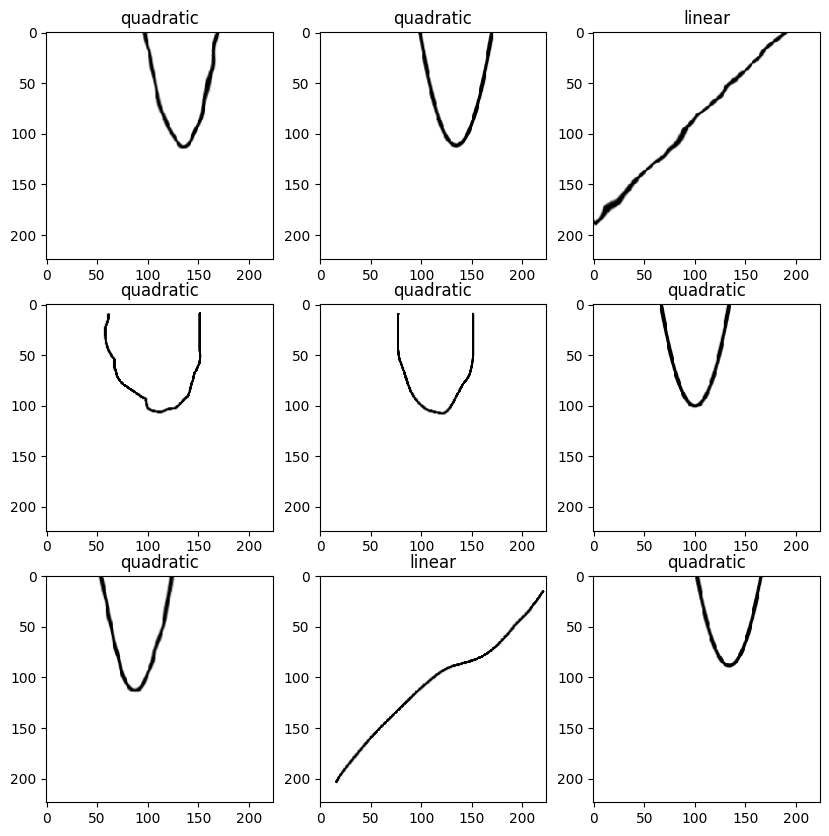

In [49]:
plt.figure(figsize=(10, 10))

for images, labels in df_train_.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_index = np.argmax(labels[i].numpy()) # Returns the indices of the maximum values.
    plt.title(class_names[label_index])



## Dataset Optimization

In [50]:
AUTOTUNE = tf.data.AUTOTUNE

df_train = (
    df_train_
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
df_valid = (
    df_valid_
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## Model Definition

In [29]:

model = tf.keras.Sequential([
    layers.Resizing(224, 224, interpolation='nearest'),
    layers.Rescaling(1./255, input_shape=(1, 1, 3)),
    hub.KerasLayer(
        "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-224-feature-vector/2",
        trainable=False
        ),  
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(2, activation='softmax')
])

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x13ae7ee90> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [ ]:
history = model.fit(
    df_train,
    validation_data=df_valid,
    epochs=5
    )

Epoch 1/5
11/11 [==============================] - 3s 74ms/step - loss: 0.4955 - binary_accuracy: 0.7178 - val_loss: 0.5654 - val_binary_accuracy: 1.0000
Epoch 2/5
11/11 [==============================] - 1s 49ms/step - loss: 0.2999 - binary_accuracy: 1.0000 - val_loss: 0.5165 - val_binary_accuracy: 1.0000
Epoch 3/5
11/11 [==============================] - 1s 47ms/step - loss: 0.2489 - binary_accuracy: 1.0000 - val_loss: 0.4856 - val_binary_accuracy: 1.0000
Epoch 4/5
11/11 [==============================] - 1s 51ms/step - loss: 0.2273 - binary_accuracy: 1.0000 - val_loss: 0.4525 - val_binary_accuracy: 1.0000
Epoch 5/5
11/11 [==============================] - 1s 49ms/step - loss: 0.2102 - binary_accuracy: 1.0000 - val_loss: 0.4217 - val_binary_accuracy: 1.0000


<Axes: >

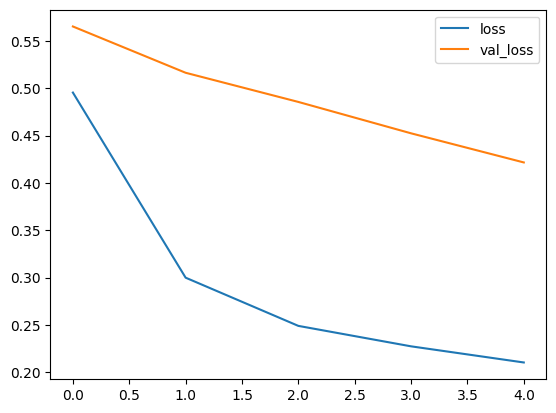

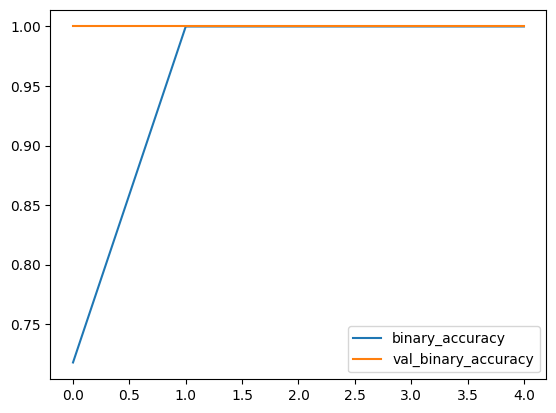

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

## Save the Model

In [ ]:
model.save("model.keras")

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1280)              410208    
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 7686      
                                                                 
 dense_3 (Dense)             (None, 2)                 14        
                                                                 
Total params: 417908 (1.59 MB)
Trainable params: 7700 

Test prediction of one image

In [ ]:
model_loaded = keras.saving.load_model("model.keras", custom_objects={'KerasLayer':hub.KerasLayer})
img = Image.open("/Users/anna-alexandradanchenko/Documents/University/IdentMathFunc/Math-Functions-Identification/data/quadratic/function_2.0_0.0.png").resize((224, 224))
img = np.array(img)
prediction = model_loaded.predict(img[None,:,:])
pred_class = np.argmax(prediction)
print(class_names[pred_class])

1/1 [==============================] - 0s 247ms/step
quadratic
